In [1]:
import jax
import jax.numpy as np
import jax.random as jr
import optax
import equinox as eqx 
import diffrax 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

# Unsupervised learning
- In unsupervised learning we only have the inputs to our function, but no labels/targets/outputs. But we still want to learn a function that gives useful insight to the input data
- Consider the images used previously:
    - they are high dimensional vectors (in $\mathbf{R}^{784}$).
    - However, actual images of handwritten digits is a very small subset of all possible 28*28 images
    - We assume/hypothesise that the dataset x_train exists on some lower dimensional manifold, embedded in $\mathbf{R}^{784}$
    - Can we learn a projection onto that manifold?

In [2]:
SEED = 1234
key = jr.PRNGKey(SEED) # JAX is very explicit with pseudo-random numbers, such that everything can be kept as a "pure" function when needed

## Import the MNIST dataset as before
 - although now we only really care about X

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,np.newaxis] / 255.0

x_test = x_test[:,np.newaxis] / 255.0

2024-02-21 16:23:20.269462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 16:23:20.269545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 16:23:20.313971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 16:23:21.931555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Lets define a convolutional autoencoder
- Here the `eqx.nn.Conv2D` layers perform 2d convolutions
- `eqx.nn.MaxPool2d` downsamples to smaller images
- `eqx.ConvTranspose2d` upsamples again to higher resolution
- For convenience and clarity we defined `.encode` and `.decode` methods that map to and from the latent space, and the `__call__` method just does an encode followed by a decode
   - If trained properly, encode and decode should be inverses of each other

In [4]:
class Autoencoder(eqx.Module):
    layers: list

    def __init__(self, key,channels=1):
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)
        # Standard CNN autoencoder - consecutive layers get narrower via MaxPool2d, and the expanded out again via ConvTranspose2d
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(channels, 8, kernel_size=6, key=key1),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.leaky_relu,
            eqx.nn.Conv2d(8, 4, kernel_size=5, key=key2),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.leaky_relu,
            eqx.nn.Conv2d(4, 4, kernel_size=4, key=key3),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.leaky_relu,
            eqx.nn.ConvTranspose2d(4,4,kernel_size=4,key=key4),
            jax.nn.leaky_relu,
            eqx.nn.ConvTranspose2d(4,8,kernel_size=5,stride=2,key=key5),
            jax.nn.leaky_relu,
            eqx.nn.ConvTranspose2d(8,channels,kernel_size=6,key=key6),
            
            
        ]

    def encode(self,x):
        for i in range(0,9):
            x = self.layers[i](x)
        return x
    
    def decode(self,x):
        for i in range(9,14):
            x = self.layers[i](x)
        return x
    def __call__(self, x):
        x = self.encode(x)
        x = self.decode(x)
        
        return x

## We can also add other functions into our model
- `eqx.Modules` are pretty general - we don't have to stick to things in the equinox library
- Lets explore using fast fourier transforms (FFT) as part of the encoding process, and inverse FFTs in the decoder
- We can also use one `eqx.Module` subclass in another, so we can just use the same layers as are in `Autoencoder` and sandwich them between FFT and iFFT

In [5]:
class FFT_Autoencoder(eqx.Module):
    fft_layers: list
    ifft_layers: list
    autoencoder_model: Autoencoder
    def __init__(self,key):
        self.autoencoder_model = Autoencoder(key,channels=2) # Using 2 channels for real and imaginary components
         

    
        def concat(c):
            re = c.real
            im = c.imag
            return np.concatenate((re,im),axis=0)
    
        def unconcat(re_im):
            c = re_im[0] + re_im[1]*1j
            c = c[np.newaxis]
            return c
        
        self.fft_layers = [np.fft.fft2,
                           lambda x:np.fft.fftshift(x,axes=(-1,-2)),
                           concat]
        self.ifft_layers=[unconcat,
                          lambda x:np.fft.ifftshift(x,axes=(-1,-2)),
                          lambda x:np.fft.irfft2(x,s=(28,28))]

    def encode(self,x):
        for L in self.fft_layers:
            x = L(x)
        x = self.autoencoder_model.encode(x)
        return x
        
    def decode(self,x):
        x = self.autoencoder_model.decode(x)
        for L in self.ifft_layers:
            x = L(x)
        return x

    def __call__(self,x):
        x = self.encode(x)
        x = self.decode(x)
        return x
        
    

## Define a loss function
- Here just a mean square distance will do

In [6]:
def loss(model,X):
    v_model = jax.vmap(model,in_axes=0,out_axes=0)
    pred = v_model(X)
    return np.mean((pred-X)**2)

## Define the training procedure
- This is pretty standard and almost the same as before, except we are only using $X$

In [7]:
def train(model,steps,LEARN_RATE=1e-3,BATCH_SIZE=128):

    optim = optax.adam(LEARN_RATE)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_log = []
    
    @eqx.filter_jit # Wrap this in a filter_jit to speed things up
    def make_step(model,opt_state,X):
        loss_value,grad = eqx.filter_value_and_grad(loss)(model,X)
        updates, opt_state = optim.update(grad, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
   
    train_key = jr.fold_in(key,1)
    for i in tqdm(range(steps)):
        train_key = jr.fold_in(train_key,i)
        # Choose which samples from x_train to fit to this iteration
        inds = jr.choice(train_key,np.arange(60000),(BATCH_SIZE,),replace=False)
        x = x_train[inds]
        
        # Do the actual gradient update
        model, opt_state, train_loss = make_step(model, opt_state, x)
        loss_log.append(train_loss)
        if i%10==0:
            tqdm.write("Loss at step "+str(i)+": "+str(train_loss))
    
    return model,loss_log

### Lets see if adding FFTs as a preprocessing step helped

In [8]:
subkey = jr.fold_in(key,int(time.time()))
key1,key2 = jr.split(subkey)
model = Autoencoder(key1)
model_fft = FFT_Autoencoder(key2)

In [9]:
model_fft_trained,losses_fft = train(model_fft,1000,LEARN_RATE=1e-2,BATCH_SIZE=32)
model_trained,losses = train(model,1000,LEARN_RATE=1e-2,BATCH_SIZE=32)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.11396565
Loss at step 10: 0.11155717
Loss at step 20: 0.10384742
Loss at step 30: 0.10485035
Loss at step 40: 0.10597076
Loss at step 50: 0.11194127
Loss at step 60: 0.09986796
Loss at step 70: 0.09650511
Loss at step 80: 0.09210079
Loss at step 90: 0.09005191
Loss at step 100: 0.08385242
Loss at step 110: 0.070062175
Loss at step 120: 0.07327917
Loss at step 130: 0.06139319
Loss at step 140: 0.061506577
Loss at step 150: 0.072034545
Loss at step 160: 0.057071596
Loss at step 170: 0.059979256
Loss at step 180: 0.06399518
Loss at step 190: 0.06084988
Loss at step 200: 0.05776096
Loss at step 210: 0.0630465
Loss at step 220: 0.05772993
Loss at step 230: 0.057961836
Loss at step 240: 0.055033777
Loss at step 250: 0.057491798
Loss at step 260: 0.06087418
Loss at step 270: 0.05966223
Loss at step 280: 0.06530458
Loss at step 290: 0.05278702
Loss at step 300: 0.055410657
Loss at step 310: 0.05940457
Loss at step 320: 0.054897103
Loss at step 330: 0.059193492
Loss at step 34

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.11595053
Loss at step 10: 0.074542485
Loss at step 20: 0.06826914
Loss at step 30: 0.06947146
Loss at step 40: 0.06936698
Loss at step 50: 0.07320465
Loss at step 60: 0.06445677
Loss at step 70: 0.064576894
Loss at step 80: 0.06584473
Loss at step 90: 0.06802457
Loss at step 100: 0.0668403
Loss at step 110: 0.060232863
Loss at step 120: 0.06531347
Loss at step 130: 0.05814885
Loss at step 140: 0.059097204
Loss at step 150: 0.07035662
Loss at step 160: 0.055810187
Loss at step 170: 0.05757681
Loss at step 180: 0.0608282
Loss at step 190: 0.058080547
Loss at step 200: 0.05294168
Loss at step 210: 0.06566662
Loss at step 220: 0.056798905
Loss at step 230: 0.055846367
Loss at step 240: 0.051139466
Loss at step 250: 0.05173321
Loss at step 260: 0.05449349
Loss at step 270: 0.05241118
Loss at step 280: 0.055500634
Loss at step 290: 0.04677037
Loss at step 300: 0.047584835
Loss at step 310: 0.05001456
Loss at step 320: 0.04439189
Loss at step 330: 0.04960314
Loss at step 340

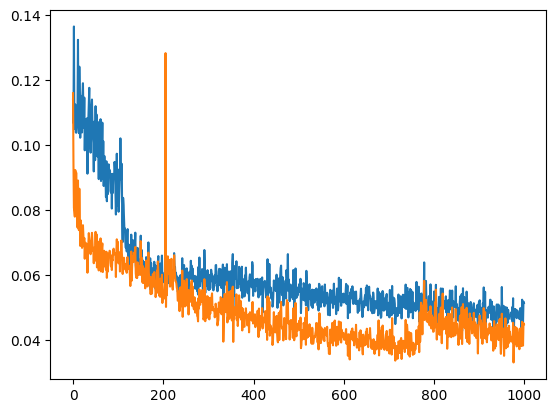

In [10]:
plt.plot(losses_fft,label="fft autoencoder")
plt.plot(losses,label="autoencoder")
plt.show()

### How to assess performance?
- the ratio between latent space and input space dimensions acts as a measure of compression ratio
- We can visualise pairs of inputs and outputs of the autoencoders
- We can also visualise aspects of the latent spaces


Compression ration: 0.25


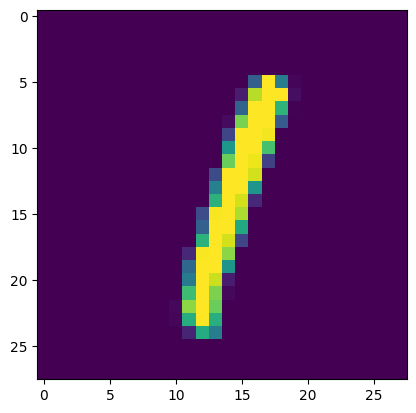

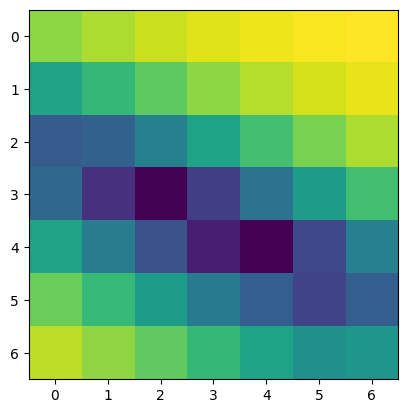

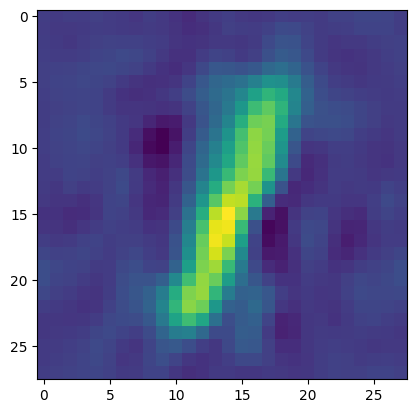

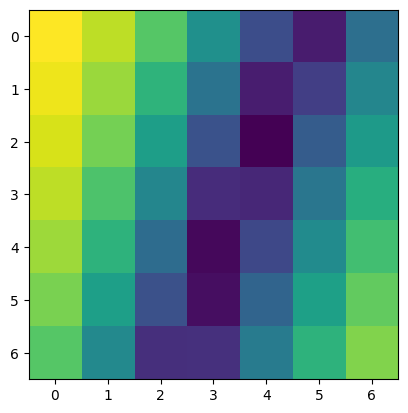

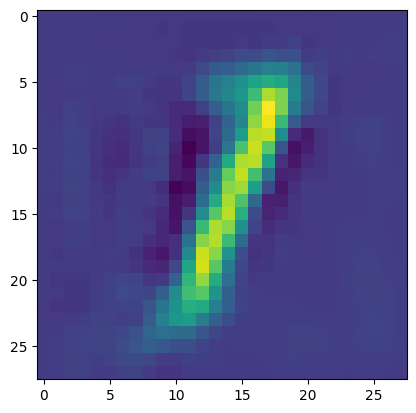

In [11]:


I = 5
embedding = model_fft_trained.encode(x_test[I])
output = model_fft_trained.decode(embedding)

embedding_fft = model_trained.encode(x_test[I])
output_fft = model_trained.decode(embedding_fft)
#print(embedding)

latent_space = embedding.flatten().shape[0]
input_space = output.flatten().shape[0]

print("Compression ration: "+str(latent_space/input_space))
plt.imshow(x_test[I,0])
plt.show()

plt.imshow(embedding[0])
plt.show()
plt.imshow(output[0])
plt.show()

plt.imshow(embedding_fft[0])
plt.show()
plt.imshow(output_fft[0])
plt.show()